In [1]:
from fastai import *
from fastai.text import*
import pandas as pd
import os

In [2]:
#bs = 192
bs = 24
os.chdir("C:/Users/Administrator/Desktop/fine_tuning")
path = Path("C:/Users/Administrator/Desktop/fine_tuning")

In [3]:
df_train = pd.read_pickle("train.pkl")
df_test = pd.read_pickle("test.pkl")
df_test["reviews.rating"] = df_test["reviews.rating"].replace({4:5,2:1})
df_train["reviews.rating"] = df_train["reviews.rating"].replace({4:5,2:1})

In [4]:
data_lm = load_data(path,"fine_tuned_new_data")

In [7]:
###try to predict
data_clas = (TextList.from_df(df_train,cols="reviews.text",vocab=data_lm.vocab)
             .split_by_rand_pct(0.3,seed=44).label_from_df(cols="reviews.rating"))

In [8]:
data_clas = data_clas.databunch(num_workers=8,bs=bs)

In [9]:
learn_c = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.35).to_fp16()


In [10]:
learn_c.load_encoder("lm_fine_tuned_new_enc1")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (23100 items)
x: TextList
xxbos xxmaj this app gives me all the weather information i need to plan my day . xxmaj it is very easy to use and well laid out . xxmaj the price is right also .,xxbos xxmaj works fine but the power cord is a bit short and you can feel the transformer shaking within the casing .,xxbos xxmaj this whole thing is just crap it wo n't download to my samsung galaxy 6 & i ca n't then get it on my laptop it 's a nightmare,xxbos xxmaj its a fancy xxunk of i xxup spy basically . xxmaj for the price of free ... it is good , but i can not see why you would pay for the full version as the ads are not that bad at all .,xxbos i wanted to make sure someone else did not buy one of these with out knowing how they worked . 1 . xxmaj with camera inside looking out window , washed out picture of outside world . 2 . xxmaj how to fill in license so s / w will run . xxmaj first 8 digits model # - second 12 digits mac number on bot

In [13]:
len(data_clas.vocab.itos)

31224

In [26]:
### extract encoder 
enc = list(learn_c.model.parameters())
numpy_enc = enc[0].cpu().detach().numpy()
numpy_enc.shape

(31224, 400)

In [27]:
pd.DataFrame(numpy_enc).to_pickle("enc_31224.pkl")

In [29]:
data_clas.save("ref_data")

In [25]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-02
Min loss divided by 10: 3.63E-02


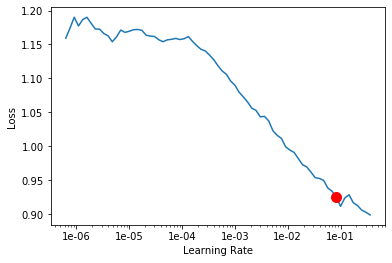

In [26]:

learn_c.recorder.plot(suggestion=True,skip_end=10)

In [27]:
min_grad=learn_c.recorder.min_grad_lr
min_grad

0.08317637711026708

In [28]:
learn_c.fit_one_cycle(2,min_grad,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.744168,0.692851,0.716263,01:29
1,0.612278,0.577864,0.764242,01:30


In [29]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2,slice(1e-3,5e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.605579,0.540696,0.778283,01:36
1,0.565406,0.516666,0.789293,01:34


In [30]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(3,slice(1e-3,5e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.675566,0.829733,0.746061,01:46
1,0.601856,0.678916,0.769596,01:45
2,0.539377,0.805895,0.788081,01:46


In [31]:
learn_c.export("final_bs_48")

In [32]:

preds,y,losses=learn_c.get_preds(with_loss=True)


interp = ClassificationInterpretation(learn_c,preds,y,losses)


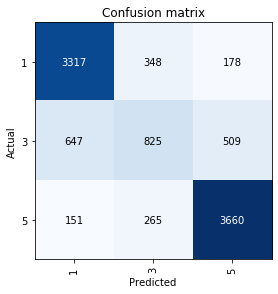

In [33]:
interp.plot_confusion_matrix()

In [34]:
interp.most_confused(min_val=2)

[(3, 1, 647), (3, 5, 509), (1, 3, 348), (5, 3, 265), (1, 5, 178), (5, 1, 151)]

In [35]:
#learn_c.export

learn_c.predict(data_clas.train_ds.x[10])
test_data = TextList.from_df(df=df_test,cols="reviews.text",vocab=data_lm.vocab)
data_clas.add_test(test_data)
preds, y= learn_c.get_preds(ds_type=DatasetType.Test)

C:\ProgramData\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


In [37]:
from sklearn.metrics import classification_report

In [42]:
pred_mat = preds.detach().numpy()
y_hat=pd.DataFrame(pred_mat).idxmax(axis=1)
y_hat.replace({0:1,1:3,2:5},inplace=True)


In [43]:
y_hat

0        1
1        3
2        1
3        1
4        3
        ..
10579    5
10580    5
10581    5
10582    1
10583    5
Length: 10584, dtype: int64

In [44]:
print(classification_report(df_test["reviews.rating"],y_hat))

              precision    recall  f1-score   support

           1       0.81      0.88      0.84      4191
           3       0.60      0.42      0.49      2069
           5       0.85      0.90      0.87      4324

    accuracy                           0.80     10584
   macro avg       0.75      0.73      0.74     10584
weighted avg       0.78      0.80      0.79     10584



In [45]:
y_hat.to_pickle("predictions_test_24.pkl")

In [53]:
model = learn_c.model
modellist = list(model.children()).copy()
#modellist[1].layers[0:3]


class my_PoolingLinearClassifier(Module):
    "Create a linear classifier with pooling."
    def __init__(self):
        self.layers= nn.Sequential(
        nn.BatchNorm1d(1200,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
        nn.Dropout(p=0.12,inplace=True),
        nn.Linear(1200,200,bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(200,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
        nn.Dropout(p=0.1,inplace=True),
        nn.Linear(200,50,bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(50,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
        nn.Dropout(p=0.1,inplace=True),
        nn.Linear(50,3,bias=True))

    def forward(self, input:Tuple[Tensor,Tensor, Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask = input
        x = masked_concat_pool(outputs, mask)
        x = self.layers(x)
        return x, raw_outputs, outputs
    
def masked_concat_pool(outputs:Sequence[Tensor], mask:Tensor)->Tensor:

    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."

    output = outputs[-1]

    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)

    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]

    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]

    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)

    return x

new_modello = nn.Sequential(modellist[0],my_PoolingLinearClassifier())


In [41]:
#learn_c1 =Learner(data_clas,new_modello)
#learn_c1 = text_classifier_learner(data_clas,new_modello,drop_mult=0.4)


#learn_c.model = new_modello
#print(list(new_modello.parameters())[0].shape,list(learn_c.model.parameters())[0].shape)
list(learn_c.model.children())[1] = my_PoolingLinearClassifier()

In [43]:
my_PoolingLinearClassifier()

my_PoolingLinearClassifier(
  (layers): Sequential(
    (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.12, inplace=True)
    (2): Linear(in_features=1200, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1, inplace=True)
    (6): Linear(in_features=200, out_features=50, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=True)
    (10): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [48]:
learn_c.model.add_module(my_PoolingLinearClassifier())


TypeError: add_module() missing 1 required positional argument: 'module'

In [30]:
learn_c.load_encoder("lm_fine_tuned_new_enc1")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (23100 items)
x: TextList
xxbos xxmaj this app gives me all the weather information i need to plan my day . xxmaj it is very easy to use and well laid out . xxmaj the price is right also .,xxbos xxmaj works fine but the power cord is a bit short and you can feel the transformer shaking within the casing .,xxbos xxmaj this whole thing is just crap it wo n't download to my samsung galaxy 6 & i ca n't then get it on my laptop it 's a nightmare,xxbos xxmaj its a fancy xxunk of i xxup spy basically . xxmaj for the price of free ... it is good , but i can not see why you would pay for the full version as the ads are not that bad at all .,xxbos i wanted to make sure someone else did not buy one of these with out knowing how they worked . 1 . xxmaj with camera inside looking out window , washed out picture of outside world . 2 . xxmaj how to fill in license so s / w will run . xxmaj first 8 digits model # - second 12 digits mac number on bot

In [49]:
learn_c1=Learner(data_clas,new_modello).to_fp16()
#learn_c1.load_encoder("lm_fine_tuned_new_enc1")


In [50]:
###now assign pretrained weights to embeddings 
list(learn_c1.model.parameters())[0] = list(learn_c.model.parameters())[0]


In [52]:
learn_c1.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AttributeError: 'list' object has no attribute 'transpose'

Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.09E-02


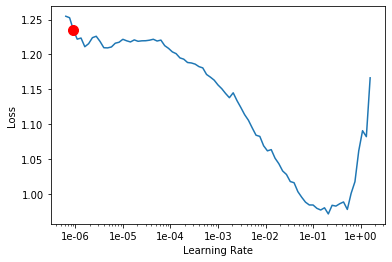

In [32]:
learn_c.recorder.plot(suggestion=True)

In [33]:
min_grad=learn_c.recorder.min_grad_lr
min_grad

9.120108393559096e-07

In [35]:
learn_c.model.children

<bound method Module.children of SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(31224, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(31224, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.13999999999999999, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3

In [55]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [56]:
INPUT_DIM = len(data_clas.vocab.stoi)
EMBEDDING_DIM = 400
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = 3#len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = data_clas.vocab.stoi[data_clas.train_ds.x.pad_idx]

In [57]:
model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)    

In [68]:
learn_cnn = Learner(data_clas,model).to_fp16()

In [69]:
learn_cnn.model.embedding.weight.data = list(learn_c.model.parameters())[0]

In [70]:
learn_cnn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Expected input batch_size (3157) to match target batch_size (24).

In [74]:
class Hook():
    def __init__(self,m:nn.Module,hook_func:HookFunc,is_forward:True,detach:True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False
        
    def hook_fn(self,module:nn.Module,input:Tensors,output:Tensors):
        if self.detach():
            input = (o.detach() for o in input) if is_listy(input) else input.detach()
            output = (o.detach() for o in output) if is_list(output) else output.detach()
        self.stored = self.hook_func(module,input,output)
    def remove(self):
        if not self.removed:
            self.hook.remove()
            self.removed=True
                
    def __enter__(self,*args): return self
    def __exit__(self,*args): self.remove()
    
def get_output(module,input_value,output):
    return output.flatten(1)

def get_input(module,input_value,output):
    return list(input_value)[0]

def get_named_module_from_model(model,name):
    for n,m in model.named_modules():
        if n == name:
            return( m)
    return None

In [75]:
model = learn_c.model
linear_output_layer= get_named_module_from_model(model,"1.layers.6")        

inference_dataloader = data_clas.train_dl.new(shuffle=False)  

In [76]:

omap = {}
with Hook(linear_output_layer,get_output,True,True) as hook:
    
    for i,(xb,yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs: (i+1)*bs]
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs,-1)
        for img_id, img_repr in zip(img_ids,img_reprs):
            omap[img_id] = img_repr

TypeError: 'bool' object is not callable